## Generative Models for Low Rank Representation and Reconstruction of Videos
In this notebook, we show how to use our proposed low rank and similarity constraint with joint optimization of latent codes and generator weights to represent and reconstruct video sequences from different measurements. Here, we demonstrate reconstruction from linear Gaussian measurements and inpainted sequences with missing pixels. We have also kept options for latent code optimization and generator weight optimization separately.

### Load necessary modules        

In [1]:
from glob import glob
from scipy import misc, linalg
import torch
from os.path import isfile, isdir
from os import mkdir
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Set the directory for video sequence
At first set the directory where the video frames are stored. The code will consider all the alphabetically ordered .jpg images in that directory as a single video sequence.

In [2]:
sequence_dir='data/walking/seq2/'

### Set image size and type
We should set image height, width and number of channels. Our generator stucture here generates images of $64\times64$ size.

In [3]:
ngf = 64 # Height
ndf = 64 # Width
nc  = 3  # Channel

### Load test video sequence

In [4]:
sequence_files=sorted(glob(sequence_dir+'*.jpg'))
sequence_size=len(sequence_files)
print('Number of frames in sequence: '+str(sequence_size))
#print('Frames are:')
#print(sequence_files)
x_test=[]
for i in range (0,sequence_size):
    img=misc.imread(sequence_files[i])
    img=misc.imresize(img,[ngf,ndf])
    img=img/255.0
    if nc==3:
        temp=np.zeros((nc,img.shape[0],img.shape[1]))    
        for chan in range (0,temp.shape[0]):
            temp[chan,:,:]=img[:,:,chan]        
    elif nc==1:
        temp=np.zeros((nc,img.shape[0],img.shape[1]))          
        temp[0,:,:]=img[:,:]
    x_test.append(temp)
x_test=np.array(x_test)
x_test_org=x_test

Number of frames in sequence: 55


### Measurement parameters
This script supports identity mapping, random measurements or inpainting with missing pixels.

In [5]:
measurement_type='missing' #'original', 'linear','missing'
num_measurements=512 # Used only for linear measurements
missing_ratio=0.8  # Used only for missing pixels
if measurement_type=='original':
    num_measurements=ngf*ndf*nc
elif measurement_type=='missing':      
    num_measurements=np.int(ngf*ndf*nc*(1-missing_ratio))
matrix_id=1

### Set low rank and similarity constraint parameter
Here we set the rank of the latent code representation and the process (either SVD or PCA). If we select low_rank=0, low rank constraint is not applied. We also set the weight on similarity constraint here.

In [6]:
low_rank=2 # Can be at most max([z_dim,sequence_size]), If it is 0, then low rank constraint is not applied
low_rank_type='pca' #'svd': Select top r singular value; 'pca': Select mean and top r-1 pca components
lamda= 1 # Weight on similarity constraint, total loss= lamda* MSE+ (1-lamda)* similarity constraint

### Set update type and optimization parameters
Here we select whether we update only latent codes (latent), or only network weights (gen) or both (joint). We learning rate for optiization of both latent code and generator weights. Here the learning rates are chosen for a specific measurements. They might need to be changed for different measurements. We also set the mini batch size and number of epochs here.

In [7]:
update_type='joint'#'latent','gen','joint'
test_size=sequence_size
test_epochs=2000
test_batch_size=sequence_size
lr=0.001*test_batch_size/256.0       # Learning rate for network weights
alpha=200.0*test_batch_size/256.0    # Learning rate for latent codes
pretrained=1 # If it is 1, we will use pretrained generator weights. Otherwise, we will use random initialization

### Prepare measurement matrix

In [8]:
if isfile('measurement_matrix/batch_'+str(test_batch_size)+'_'+str(measurement_type)+'_'+str(num_measurements)+'_'+str(matrix_id)+'.npy'):
    A=np.load('measurement_matrix/batch_'+str(test_batch_size)+'_'+str(measurement_type)+'_'+str(num_measurements)+'_'+str(matrix_id)+'.npy')

elif measurement_type=='linear':
    A =np.random.normal(loc=0.0, scale=1.0/np.sqrt(num_measurements), size=(test_batch_size,num_measurements,nc*ngf*ndf))
    if not isdir('measurement_matrix'):
        mkdir('measurement_matrix')
    np.save('measurement_matrix/batch_'+str(test_batch_size)+'_'+str(measurement_type)+'_'+str(num_measurements)+'_'+str(matrix_id),A)
             
elif measurement_type=='missing':    
    A=np.ones((test_batch_size,nc,ngf,ndf))
    idx=np.arange(ngf*ndf)
    for i in range (0,test_batch_size):
        A_temp =np.ones((1,ngf*ndf))
        np.random.shuffle(idx)                
        A_temp[0,idx[0:np.int(ngf*ndf*missing_ratio)]]=0

        A_temp=np.reshape(A_temp,(ngf, ndf))
        A_c=np.zeros((ngf,ndf,nc))
        for j in range (0,nc):
            A_c[:,:,j]=A_temp            
        for j in range (0,nc):
            A[i,j,:,:]=A_c[:,:,j]
    if not isdir('measurement_matrix'):
        mkdir('measurement_matrix')
    np.save('measurement_matrix/batch_'+str(test_batch_size)+'_'+str(measurement_type)+'_'+str(num_measurements)+'_'+str(matrix_id),A)

### Prepare measurements

In [9]:
if measurement_type=='linear':
    x_test=2*x_test_org-1
    x_test_temp=np.zeros((x_test.shape[0],num_measurements,1))
    for i in range (0, x_test.shape[0]):
        x_test_temp[i,:,:]=np.matmul(A[i%test_batch_size,:,:],x_test[i,:,:,:].reshape(1,nc*ngf*ndf,1))
    x_test=x_test_temp
elif measurement_type=='original': 
    x_test=2*x_test_org-1
    x_test=x_test  
elif measurement_type=='missing':
    x_test_temp=np.zeros((x_test.shape[0],nc,ngf,ndf))
    for i in range (0, x_test.shape[0]):
        x_test_temp[i,:,:]=np.multiply(x_test_org[i,:,:,:],A[i%test_batch_size,:,:,:])
    x_test=x_test_temp
    x_test=2*x_test-1

We show 10 frames for true sequence and inpainted sequence (if the chosen measurement is inpainted).

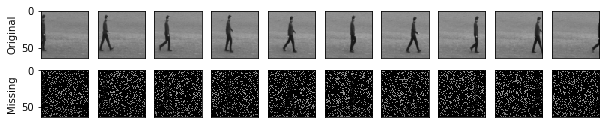

In [10]:
n=10 
figset=np.uint16(np.linspace(0,sequence_size-1,n))

corrupt=0
if measurement_type=='missing':
    corrupt=1
_=plt.figure(figsize=(n, 1+corrupt))

for i in range(n):
    # display original
    if nc==1:
        ax = plt.subplot(1+corrupt, n, i +1);
        plt.imshow(x_test_org[figset[i]].reshape(ngf, ndf));
        plt.gray();
        ax.get_xaxis().set_visible(False);
        ax.get_yaxis().set_visible(False);
        if i==0:
            ax.get_yaxis().set_visible(True)
            ax.set_ylabel('Original')
            
        if corrupt==1:
            ax = plt.subplot(1+corrupt, n, i +1+n);
            _=plt.imshow((x_test[figset[i]]/2+0.5).reshape(ngf, ndf));
            _=plt.gray();
            ax.get_xaxis().set_visible(False);
            ax.get_yaxis().set_visible(False);
        if i==0:
            ax.get_yaxis().set_visible(True)
            ax.set_ylabel('Missing')

    elif nc==3:
        ax = plt.subplot(1+corrupt, n, i+1 );
        temp=x_test_org[figset[i]];
        temp1=np.zeros((ngf, ndf,nc));
        for chan in range (0,nc):
            temp1[:,:,chan]=temp[chan,:,:];
        plt.imshow(temp1);
        ax.get_xaxis().set_visible(False);
        ax.get_yaxis().set_visible(False);
        if i==0:
            ax.get_yaxis().set_visible(True)
            ax.set_ylabel('Original')
            
        if corrupt==1:
            ax = plt.subplot(1+corrupt, n, i+1 +n);
            temp=x_test[figset[i]]/2+0.5;
            temp1=np.zeros((ngf, ndf,nc));
            for chan in range (0,nc):
                temp1[:,:,chan]=temp[chan,:,:]
            _=plt.imshow(temp1);
            ax.get_xaxis().set_visible(False);
            ax.get_yaxis().set_visible(False);
        if i==0:
            ax.get_yaxis().set_visible(True)
            ax.set_ylabel('Missing')


_=plt.show();

## Generator network
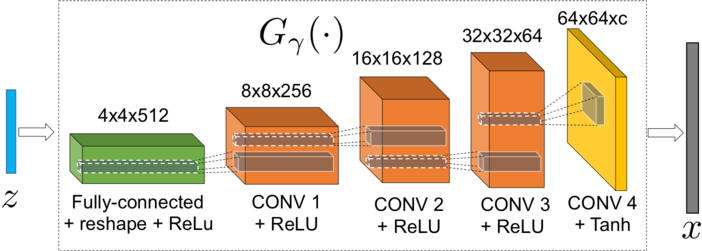

### Latent code initialization
Here we set the length of latent code and mode of initialization of the latent codes of the sequence. We can fix the same initial code for all the frames of the sequence (fixed_z), we can initialize all the frames of the sequence with different initial codes but with a fixed seed (fixed_seed) or we can initialize latent codes totally randomly (random_seed or anything). Our pretrained RGB image generator is for latent code of length 256 and grayscaled image generator is for latent code of length 32. It can be changed if we do not initialize network weights with the given pretrained generator.


In [11]:
if nc==3:
    z_dim=256  # Dimension of latent code 
elif nc==1:
    z_dim=32  # Dimension of latent code    
z_init='fixed_z' # fixed_z, fixed_seed, random_seed
seed=100 # Used when fixed seed or fixed_z is selected
z_test=np.zeros((x_test.shape[0],z_dim))
if z_init=='fixed_seed':
    np.random.seed(seed)
for i in range (0,z_test.shape[0]): 
    if z_init=='fixed_z':
        np.random.seed(seed)
    z_test[i,:]=np.random.normal(loc=0, scale=1.0, size=(1,z_dim))
    z_test[i] = z_test[i, :] / np.linalg.norm(z_test[i, :], 2)

### Generator Initialization
Here we define our generator structure and initialize generator with pretrained network weights.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
class Generator(torch.nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = torch.nn.Sequential(
            # input is Z, going into a convolution
            torch.nn.ConvTranspose2d(    z_dim, ngf * 4*(nc+1)/2, 4, 1, 0, bias=False),
            torch.nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            torch.nn.ConvTranspose2d(ngf * 4*(nc+1)/2, ngf * 2*(nc+1)/2, 4, 2,1, bias=False),
            torch.nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            torch.nn.ConvTranspose2d(ngf * 2*(nc+1)/2, ngf * 1*(nc+1)/2, 4, 2, 1, bias=False),
            torch.nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            torch.nn.ConvTranspose2d(ngf * 1*(nc+1)/2,     ngf*(nc+1)/4, 4, 2, 1, bias=False),
            torch.nn.ReLU(True),
#            # state size. (ngf) x 32 x 32
            torch.nn.ConvTranspose2d(ngf*(nc+1)/4 ,      nc, 4, 2, 1, bias=False),
            torch.nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = torch.nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output    
generator = Generator(1).to(device)
if nc==1:
    init_model='model/MNIST_dcgan.pth'   # Pretrained weights for grayscale images
elif nc==3:
    init_model='model/CIFAR10_dcgan.pth' # Pretrained weights for RGB images

### Optimization
Here we update latent code and/or network weights to solve inverse problem. We also use low rank and similarity constraint if selected in the above sections.

In [13]:
batch_no=np.int(np.ceil(test_size/np.float(test_batch_size)))
idx=np.arange(test_size)
loss_test=[]
loss_z_test=[]
x_rec=np.zeros((x_test.shape[0],nc,ngf,ndf))
for batch_idx in range(0,batch_no):
    if pretrained==1:
        generator.load_state_dict(torch.load(init_model))
    optimizer = torch.optim.Adam(generator.parameters(), lr)
    loss_epoch=[]
    loss_z_epoch=[]
    epoch_idx=idx
    
    if measurement_type=='original':
        x_batch=x_test[epoch_idx[batch_idx*test_batch_size:np.min([(batch_idx+1)*test_batch_size,test_size])],:,:,:]
        x_batch_tensor=torch.cuda.FloatTensor(x_batch).view(-1,nc,ngf,ndf)
    elif measurement_type=='missing':
        x_batch=x_test[epoch_idx[batch_idx*test_batch_size:np.min([(batch_idx+1)*test_batch_size,test_size])],:,:,:]
        x_batch_tensor=torch.cuda.FloatTensor(x_batch).view(-1,nc,ngf,ndf)
        A_tensor=torch.cuda.FloatTensor(A[epoch_idx[batch_idx*test_batch_size:np.min([(batch_idx+1)*test_batch_size,test_size])]%test_batch_size,:,:]).view(-1,nc,ngf,ndf)
    elif measurement_type=='linear':
        x_batch=x_test[epoch_idx[batch_idx*test_batch_size:np.min([(batch_idx+1)*test_batch_size,test_size])],:,0]
        x_batch_tensor=torch.cuda.FloatTensor(x_batch).view(-1, x_batch.shape[1],1)
        A_tensor=torch.cuda.FloatTensor(A[epoch_idx[batch_idx*test_batch_size:np.min([(batch_idx+1)*test_batch_size,test_size])]%test_batch_size,:,:]).view(-1,num_measurements,nc*ngf*ndf)

    for epoch in range (0,test_epochs):

        z_batch=z_test[epoch_idx[batch_idx*test_batch_size:np.min([(batch_idx+1)*test_batch_size,test_size])],:]
        z_batch_tensor=torch.autograd.Variable(torch.cuda.FloatTensor(z_batch).view(-1, z_dim, 1, 1),requires_grad=True)

        x_hat = generator(z_batch_tensor)
        if measurement_type=='linear':
            x_measure=torch.matmul(A_tensor,x_hat.view(-1, nc* ngf*ndf,1))
        elif measurement_type=='original':
            x_measure=x_hat
        elif measurement_type=='missing':
            x_hat_2=x_hat/2+0.5
            x_measure_1=torch.mul(x_hat_2,A_tensor)
            x_measure=2*x_measure_1-1

        loss_mse=(x_measure - x_batch_tensor).pow(2).mean()

        if test_batch_size>2:
            for i in range (0, np.int(np.ceil(z_batch.shape[0]/np.float(sequence_size)))):
                z_for=z_batch_tensor[i*sequence_size+1:np.min([(i+1)*sequence_size,test_batch_size]),:]
                z_back=z_batch_tensor[i*sequence_size:np.min([(i+1)*sequence_size,test_batch_size])-1,:]
                if i==0:
                    loss_z=(z_for-z_back).pow(2).mean()
                else:
                    loss_z=loss_z+(z_for-z_back).pow(2).mean()
            loss_z=loss_z

            loss=lamda*loss_mse+(1-lamda)*loss_z
        else:
            loss=lamda*loss_mse

        loss_epoch.append(loss.item())
        optimizer.zero_grad()
        loss.backward(retain_graph=True)   

        with torch.no_grad():        

            if update_type=='latent' or update_type=='joint':
                z_grad = z_batch_tensor.grad.data.cuda()
                z_update = z_batch_tensor - alpha * z_grad
                z_update = z_update.cpu().detach().numpy()
                z_update=np.reshape(z_update,z_batch.shape)
                if low_rank!=0:
                    if low_rank_type=='svd':
                        u, s, vh = np.linalg.svd(z_update, full_matrices=False)
                        z_update=np.dot(u * np.append(s[0:low_rank],np.zeros(len(s)-low_rank)), vh)
                    elif low_rank_type=='pca':
                        z_mean=np.mean(z_update,axis=0)
                        z_temp=z_update-z_mean
                        u, s, vh = np.linalg.svd(z_temp, full_matrices=False)
                        z_new=np.dot(u * np.append(s[0:low_rank-1],np.zeros(len(s)-low_rank+1)), vh)
                        z_update=z_new+z_mean
                z_test[epoch_idx[batch_idx*test_batch_size:np.min([(batch_idx+1)*test_batch_size,test_size])],:]=z_update
                
        if update_type=='gen' or update_type=='joint':
            optimizer.zero_grad()
            loss.backward()   
            optimizer.step()
            
        z_update_tensor=torch.autograd.Variable(torch.cuda.FloatTensor(z_test[epoch_idx[batch_idx*test_batch_size:np.min([(batch_idx+1)*test_batch_size,test_size])],:]).view(-1, z_dim, 1, 1))    
        x_hat = generator(z_update_tensor)
        x_rec[epoch_idx[batch_idx*test_batch_size:np.min([(batch_idx+1)*test_batch_size,test_size])],:]=np.reshape(x_hat.cpu().detach().numpy(),(x_batch.shape[0],nc,ngf,ndf))

    loss_test .append(np.array(loss_epoch))
# Converting the reconstruction to [0,1] range    
x_rec=x_rec/2+0.5

### Loss curve
We plot average loss vs epoch here to test convergence.

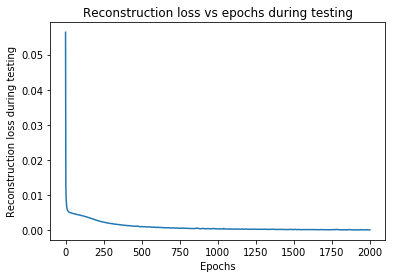

In [14]:
plt.figure()
plt.plot(np.mean(np.array(loss_test),axis=0))  
plt.xlabel('Epochs')
plt.ylabel('Reconstruction loss during testing')
plt.title('Reconstruction loss vs epochs during testing')    
plt.show();

### Results

#### PSNR
We calculate the PSNR of the reconstructions.

In [15]:
mse=np.mean((x_rec-x_test_org)**2)
psnr=20*np.log10((np.max(x_test_org)-np.min(x_test_org))/np.sqrt(mse))
print('PSNR: ' +str(psnr))

PSNR: 27.107301894770266


#### Sample reconstructions
We show 10 frames of true sequence, inpainted sequence (if the chosen measurement is inpainted) and corresponding reconstructions.

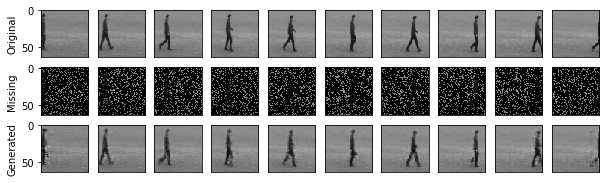

In [16]:
n=10  
figset=np.uint16(np.linspace(0,sequence_size-1,n))

corrupt=0
if measurement_type=='missing':
    corrupt=1
plt.figure(figsize=(n, 2+corrupt))

for i in range(n):
    # display original
    if nc==1:
        # Plot original
        ax = plt.subplot(2+corrupt, n, i + 1)

        plt.imshow(x_test_org[figset[i]].reshape(ngf, ndf))
        plt.gray()       
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i==0:
            ax.get_yaxis().set_visible(True)
            ax.set_ylabel('Original')

        # Plot inpainted
        if corrupt==1:            
            ax = plt.subplot(2+corrupt, n, i + 1+(0+corrupt)*n)
            plt.imshow((x_test[figset[i]]/2+0.5).reshape(ngf, ndf))
            plt.gray()                 
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i==0:
                ax.get_yaxis().set_visible(True)
                ax.set_ylabel('Missing')
                
        # Plot reconstruction
        ax = plt.subplot(2+corrupt, n, i + 1+(1+corrupt)*n)
        plt.imshow(x_rec[figset[i]].reshape(ngf, ndf))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i==0:
            ax.get_yaxis().set_visible(True)
            ax.set_ylabel('Generated')




    elif nc==3:
                
        # Plot original
        ax = plt.subplot(2+corrupt, n, i + 1)
        temp=x_test_org[figset[i]]
        temp1=np.zeros((ngf, ndf,nc))
        for chan in range (0,nc):
            temp1[:,:,chan]=temp[chan,:,:]
        plt.imshow(temp1)
        plt.gray()       
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i==0:
            ax.get_yaxis().set_visible(True)
            ax.set_ylabel('Original') 
        
        # Plot inpainted                
        if corrupt==1:

            ax = plt.subplot(2+corrupt, n, i + 1+(0+corrupt)*n)
            temp=x_test[figset[i]]/2+0.5
            temp1=np.zeros((ngf, ndf,nc))
            for chan in range (0,nc):
                temp1[:,:,chan]=temp[chan,:,:]
            plt.imshow(temp1)         
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i==0:
                ax.get_yaxis().set_visible(True)
                ax.set_ylabel('Missing')  
        
        # Plot reconstruction
        ax = plt.subplot(2+corrupt, n, i + 1+(1+corrupt)*n)
        temp=x_rec[figset[i]]
        temp1=np.zeros((ngf, ndf,nc))
        for chan in range (0,nc):
            temp1[:,:,chan]=temp[chan,:,:]
        plt.imshow(temp1)
     
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i==0:
            ax.get_yaxis().set_visible(True)
            ax.set_ylabel('Generated')
 
plt.show();

### Visualize latent code manifold
If the rank= 2 constraint is used, we show the embedding of each latent code in terms of two orthogonal basis vectors. Corresponding annotations for each latent code can be turned off for large sequences.

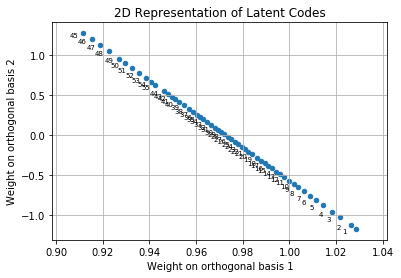

In [17]:
if low_rank==2:        
    zt=z_test
    u, s, vh = np.linalg.svd(zt, full_matrices=False)
    zt=np.dot(u * np.append(s[0:low_rank],np.zeros(len(s)-low_rank)), vh)

    # Calculate orthogonal basis
    zb=linalg.orth(zt.T)
    zb=zb.T
    # Calculate representation with respect to orthogonal bases
    a=np.matmul(zt[0:sequence_size,:],np.linalg.pinv(zb))
    
    # Show embedding
    area=20
    show_annotation=1
    xanote_shift= -0.006 # 0
    yanote_shift=-0.05 # 0
    
    _=plt.figure()
    start_seq=0
    end_seq=sequence_size  
    _=ax=plt.subplot()
    _=plt.scatter(a[start_seq:end_seq,0], a[start_seq:end_seq,1],s=area,alpha=1)
    _=plt.grid(True)
    _=plt.xlabel('Weight on orthogonal basis 1')
    _=plt.ylabel('Weight on orthogonal basis 2')
    _=plt.title('2D Representation of Latent Codes')
    if show_annotation==1:
        for i in range(a.shape[0]):
           _=ax.annotate(str(i+1), (a[i,0]+xanote_shift, a[i,1]+yanote_shift), fontsize=7)  
    plt.show();